# Sparkify Project Workspace


### Project overview

This project was made as final capstone on Udacity Data Science Nanodegree by Pedro Rocha.

Sparkify is a simulated digital music service as Spotify or Pandora.

Millions of users stream music from the app every day using the free or paid version.

They can upgrade, downgrade or cancel their account at any time. So it's important to make sure that users love the service!

The full dataset is 12GB but in this notebook we'll analyze and deploy ML models in a small subset.

### Problem Statement

The objective of the project is create a model that can predict users churn.

It's important to predict when a users are going to cancell their accounts in order to act, offering discounts and incentives.

First we'll clean the data set, analyze the data and then perform feature engineering to deploy a ML classificator to achieve our goal.

For this project we'll use **SPARK**, so after analyze this small subset we can scale the analysis to the full dataset in a spark cluster.

Project process:

1- Clean data set: finding missing values, understanding the structure of the dataset, understanding column’s datatypes.

2- Data Exploration and Visualization: analyze user behavior, get useful insights on data and visualize calculated statistics.

3- Feature Engineering: select features based on the previous steps and put all together into one dataframe.

4- Modeling: Initialize and train three machine learning algorithms: Logistic Regression, Random Forest and Gradient Boosted Trees. Use CrossValidation to search for best parameters combination.

5- Model Evaluation and Validation: Then I’ll predict results on test and compare perfomance them based on metrics F1 Score, and provide some discussion about the choosen model.

### Metrics

To evaluate our models we'll use **F1-Score**.

F1-score is a performance measure that takes into account both false positives and false negatives. It is useful when class distribution is unbalanced, as in our case.

Sparkify aims to identify the majority of users who might leave but at the same time we don’t want to give too many discounts for no reason (false positives) or miss out on those who actually cancel the service (false negatives).

$$ F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, desc, lit, min, max, udf, when, count
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import  StandardScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify - Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset

In [3]:
sparkify_events = spark.read.json("mini_sparkify_event_data.json")
sparkify_events.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's see how the data set looks

In [4]:
#Show first row
sparkify_events.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

Show data schema

In [5]:
#Print schema
sparkify_events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's see if we've Nans in the columns

In [6]:
print('Missing Values\n')

for column in sparkify_events.columns:
    missing_values = sparkify_events.where(col(column).isNull()).count()
    missing_values += sparkify_events.where(col(column) == "").count()
    print(column,':', missing_values)

Missing Values

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 8346


We've 8346 missing values in $userId$ column, we need an identification for our goals so that we'll drop rows with no value in this column.

In [7]:
#Filter dataframe with no missing values in userId column
sparkify_events = sparkify_events.where((sparkify_events.userId != "") & (sparkify_events.userId.isNotNull()))

#Check missing values
missing_values = sparkify_events.where(col('UserId').isNull()).count()
missing_values += sparkify_events.where(col('UserId') == "").count()
print('UserId missing values:', missing_values)

UserId missing values: 0


Check all columns after drop rows without $userId:$

In [8]:
print('Missing Values\n')

for column in sparkify_events.columns:
    missing_values = sparkify_events.where(col(column).isNull()).count()
    missing_values += sparkify_events.where(col(column) == "").count()
    print(column,':', missing_values)

Missing Values

artist : 50046
auth : 0
firstName : 0
gender : 0
itemInSession : 0
lastName : 0
length : 50046
level : 0
location : 0
method : 0
page : 0
registration : 0
sessionId : 0
song : 50046
status : 0
ts : 0
userAgent : 0
userId : 0


We'll create two columns to have an easy datetime format

In [9]:
#create functions to extract date and time from timestamp
get_date = udf(lambda ts: datetime.datetime.fromtimestamp(ts/1000).strftime("%Y-%m-%d"))
get_hour = udf(lambda ts: datetime.datetime.fromtimestamp(ts/1000).strftime("%H"))

In [10]:
#Create two columns for date and time
sparkify_events = sparkify_events.withColumn('date',get_date(sparkify_events.ts))
sparkify_events = sparkify_events.withColumn('hour',get_hour(sparkify_events.ts))

Let's see first 5 rows in a pandas dataframe format

In [11]:
events_df = sparkify_events.toPandas()
events_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,date,hour
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01,00
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01,00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01,00
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01,00
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01,00


# Exploratory Data Analysis


It'd be interesting to see how users listen to music through the day...

In [12]:
#Create a pandas DF with songs played each hour of day
songs_by_hour = sparkify_events.filter("page == 'NextSong'").groupBy('hour').count().orderBy('hour').toPandas()
#Rename column
songs_by_hour = songs_by_hour.rename(columns = {'count':'Songs Played'})
#show df
songs_by_hour

,hour,Songs Played
0,00,9062
1,01,8388
2,02,8336
3,03,8355
4,04,8147
5,05,8178
6,06,8054
7,07,8091
8,08,8253
9,09,8498


Plot the results:

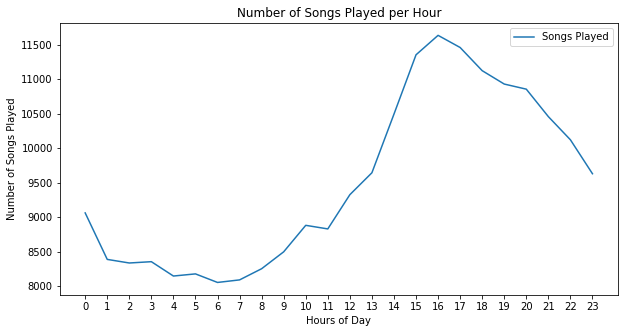

In [13]:
songs_by_hour.plot(kind = "line", figsize= (10,5))
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played per Hour")
plt.show();

We want to know the possible events. Let's check unique values for column $page$:

In [14]:
#See unique values for page, it shows possible events
sparkify_events.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



See possible values for column $level$

In [15]:
#See unique values for level, it shows possible account level
sparkify_events.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



How many unique users are in the data set?

In [16]:
#Count unique userid

print('Unique users:', sparkify_events.select('userId').distinct().count())

Unique users: 225


Now we want to check data we can use to create our Churn column.

First we'll label the users that cancell their account

In [17]:
#save ids for users who churned and downgraded

#Select users who churned
churned_userIds = sparkify_events.select('userId').where("page == 'Cancellation Confirmation'").dropDuplicates().collect()
#Convert rows to list
churned_userIds = [user.userId for user in churned_userIds]

#Select users who downgraded
downgraded_userIds = sparkify_events.select('userId').where("page == 'Submit Downgrade'").dropDuplicates().collect()
#Convert rows to list
downgraded_userIds = [user.userId for user in downgraded_userIds]

Check for users who first downgrade and then cancel account

In [18]:
print(len(np.intersect1d(np.array(churned_userIds),np.array(downgraded_userIds))),'users downgrade before cancel the account')

9 users downgrade before cancel the account


In [19]:
#Create a column to label users that cancell their account with 1
sparkify_events = sparkify_events.withColumn('churn', when(col("userId").isin(churned_userIds),1).otherwise(0))

#Create a column to label users that downgrade their level with 1
sparkify_events = sparkify_events.withColumn('downgrade',when(col("userId").isin(downgraded_userIds),1).otherwise(0))

sparkify_events.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date='2018-10-01', hour='00', churn=0, downgrade=1)

Now it's time to explore the differences in behaviour between users who churned the service and the ones who don't 

### Number of thumbs up and down per user

Groupby userId and count Thumbs Up and Down. Then join the two columns to put all together

In [20]:
#Group and count Thumbs UP

thumbs_up = sparkify_events.select('userId','page','churn').where("page = 'Thumbs Up'").groupBy(['churn','userId']).agg(count('page').alias('Thumbs Up'))
thumbs_up.head()

Row(churn=0, userId='114', Thumbs Up=74)

In [21]:
#Group and count Thumbs Down

thumbs_down = sparkify_events.select('userId','page','churn').where("page = 'Thumbs Down'").groupBy(['churn','userId']).agg(count('page').alias('Thumbs Down'))
thumbs_down.head()

Row(churn=0, userId='114', Thumbs Down=12)

Joint the two dataframes and calculate the AVG thumbs (Up and Down) per user in both groups

In [22]:
#Join dataframes by userId
thumbs = thumbs_down.join(thumbs_up.select('userId','Thumbs Up'), 'userId')
#Calculate avg for each group
thumbs = thumbs.select('churn','Thumbs Down','Thumbs Up').groupBy('churn').agg(avg('Thumbs Down').alias('Avg Thumbs Down'),avg('Thumbs Up').alias('Avg Thumbs Up'))
thumbs.head(2)

[Row(churn=1, Avg Thumbs Down=10.53191489361702, Avg Thumbs Up=39.276595744680854),
 Row(churn=0, Avg Thumbs Down=13.225806451612904, Avg Thumbs Up=68.53548387096774)]

In [23]:
print('AVG proportion of Thumbs Down in group 0:',13.225806451612904/(68.53548387096774 + 13.225806451612904))
print('AVG proportion of Thumbs Down in group 1:',10.53191489361702/(39.276595744680854 + 10.53191489361702))

AVG proportion of Thumbs Down in group 0: 0.1617612246508325
AVG proportion of Thumbs Down in group 1: 0.21144809910294743


In [24]:
#set plt style
plt.style.use('bmh')
plt.style.use('seaborn-ticks')

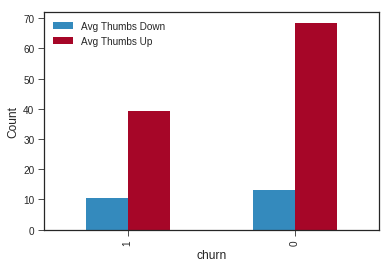

In [25]:
#Plot results
thumbs = thumbs.toPandas()
thumbs.set_index('churn',inplace=True)
thumbs.plot(kind='Bar', )
plt.ylabel('Count');

### How many friends in avg have the users in each group?

In [26]:
#Gropy by UserId and count number of friends
friends = sparkify_events.select('userId','page','churn').where("page == 'Add Friend'").groupBy(['churn','userId']).agg(count('page').alias('Friends'))
#calculate avg for each group
friends_avg = friends.select('churn','Friends').groupBy('churn').agg(avg('Friends').alias('AVG Friends'))
#Print results
print(friends_avg.head(2))

#Create pandas DF
friends_df = friends_avg.toPandas()
#Set Churn as index
friends_df.set_index('churn',inplace=True)

[Row(churn=1, AVG Friends=14.454545454545455), Row(churn=0, AVG Friends=22.47530864197531)]


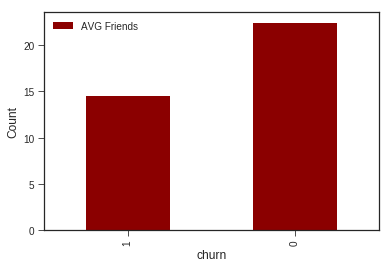

In [27]:
#plot results
friends_df.plot(kind='Bar', color = 'darkred')
plt.ylabel('Count');

In [28]:
#GroupBy user and count sessionsIds
n_sessions = sparkify_events.select('userId','sessionId','churn').distinct().groupBy(['churn','userId']).agg(count('sessionId').alias('Sessions'))
#Groupby Churn and calculate avg sessions by group and convert to pandas DF
sessions_df = n_sessions.select('churn','Sessions').groupBy('churn').agg(avg('Sessions').alias('Avg Sessions')).toPandas()

#Set churn as index
sessions_df.set_index('churn',inplace=True)
#Show df
sessions_df

,Avg Sessions
churn,
1,10.326923
0,15.254335


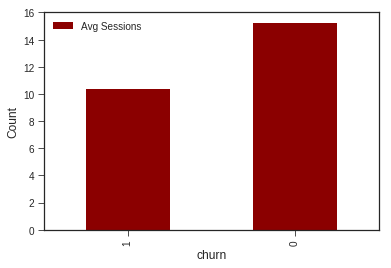

In [29]:
#Plot results
sessions_df.plot(kind='Bar', color = 'darkred')
plt.ylabel('Count');

### Songs listen to users in each group

In [30]:
#Gropy by UserId and count number of songs played
songs = sparkify_events.select('userId','page','churn').where("page == 'NextSong'").groupBy(['userId','churn']).agg(count('page').alias('Played_Songs'))
#calculate avg for each group
songs_avg = songs.select('churn','Played_Songs').groupBy('churn').agg(avg('Played_Songs').alias('AVG Played_Songs'))
#Print results
print(songs_avg.head(2))

#Create pandas DF
songs_df = songs_avg.toPandas()
#Set Churn as index
songs_df.set_index('churn',inplace=True)

[Row(churn=1, AVG Played_Songs=699.8846153846154), Row(churn=0, AVG Played_Songs=1108.1734104046243)]


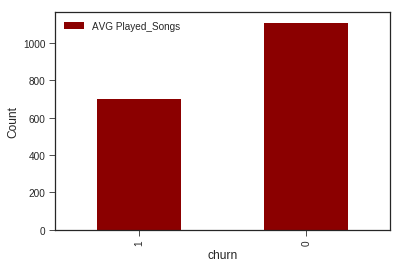

In [31]:
#plot results
songs_df.plot(kind='Bar', color = 'darkred')
plt.ylabel('Count');

### Songs added to playlist by users 

In [32]:
#Gropy by UserId and count number of songs played
playlist = sparkify_events.select('userId','page','churn').where("page == 'Add to Playlist'").groupBy(['userId','churn']).agg(count('page').alias('Playlist'))
#calculate avg for each group
playlist_avg = playlist.select('churn','Playlist').groupBy('churn').agg(avg('Playlist').alias('AVG Playlist'))
#Print results
print(playlist_avg.head(2))

#Create pandas DF
playlist_df = playlist_avg.toPandas()
#Set Churn as index
playlist_df.set_index('churn',inplace=True)

[Row(churn=1, AVG Playlist=20.76), Row(churn=0, AVG Playlist=33.26060606060606)]


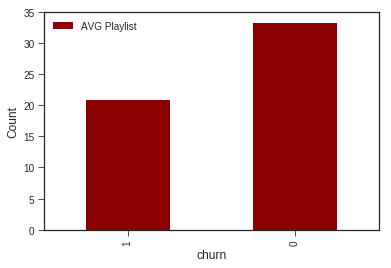

In [33]:
#plot results
playlist_df.plot(kind='Bar', color = 'darkred')
plt.ylabel('Count');

### Create features dataframe

In [34]:
#Join all features calculated above in one dataframe
sparkify_features = songs.join(n_sessions.select('userId','Sessions'),on = 'userId', how = 'outer')\
                         .join(friends.select('userId','Friends'),on = 'userId', how = 'outer')\
                         .join(thumbs_up.select('userId','Thumbs Up'),on = 'userId', how = 'outer')\
                         .join(thumbs_down.select('userId','Thumbs Down'),on = 'userId', how = 'outer')\
                         .join(playlist.select('userId','Playlist'),on = 'userId', how = 'outer')
                               
                               
#If some feature have a Nan it means user have not interacted with this page, for example never added a friend
#So that we'll replace nans with 0
sparkify_features = sparkify_features.fillna(0)

#Sort dataframe by userId
sparkify_features = sparkify_features.orderBy('userId')

#Change column name "churn" to "label"
sparkify_features = sparkify_features.withColumnRenamed('churn','label')

#Let's check how the dataframe looks
sparkify_features.head(5)

[Row(userId='10', label=0, Played_Songs=673, Sessions=6, Friends=12, Thumbs Up=37, Thumbs Down=4, Playlist=9),
 Row(userId='100', label=0, Played_Songs=2682, Sessions=35, Friends=49, Thumbs Up=148, Thumbs Down=27, Playlist=61),
 Row(userId='100001', label=1, Played_Songs=133, Sessions=4, Friends=2, Thumbs Up=8, Thumbs Down=2, Playlist=3),
 Row(userId='100002', label=0, Played_Songs=195, Sessions=4, Friends=1, Thumbs Up=5, Thumbs Down=0, Playlist=5),
 Row(userId='100003', label=1, Played_Songs=51, Sessions=2, Friends=0, Thumbs Up=3, Thumbs Down=0, Playlist=2)]

In [35]:
#Check that we've all users in dataset
sparkify_features.count()

225

### Summary

Based on what we see in our exploratory analysis, we can observe some characteristics in the behavior of the users of each group.

Users who churned the app have in average:

* Less friends
* Less Thumbs Up
* Higher proportion of Thumbs Down
* Less songs played
* Less sessions, which means that use less the app
* Add less songs to playlist

All this insights show a lower usage of the app in users that cancelled their account.

# Feature Engineering

In [36]:
#Initialize Vector Assembler
assembler = VectorAssembler(inputCols=(sparkify_features.columns[2:]),outputCol='numfeatures')

#Initialize Standard Scaler
scaler = StandardScaler(inputCol='numfeatures',outputCol='features', withMean=True, withStd=True)


# Modeling


We'll try three clasification ML models:

* Logistic Regression

* Random Forest

* GBT Classifier

### Train - Test Split

In [37]:
train, test = sparkify_features.randomSplit([0.8,0.2], seed=42)

### Logistic Regression

In [38]:
#Initialize Logistic Regression model
lr = LogisticRegression(maxIter=10, regParam = 0.0, elasticNetParam = 0)

#Set pipeline
pipeline = Pipeline(stages = [assembler,scaler,lr])

#Set param grid
paramGrid = ParamGridBuilder()\
            .addGrid(scaler.withMean,[True,False])\
            .addGrid(lr.regParam,[0.0,0.1])\
            .build()
  
#cross validation
crossval = CrossValidator(estimator = pipeline,
                         estimatorParamMaps = paramGrid,
                         evaluator= MulticlassClassificationEvaluator(),
                         numFolds = 3)


#Train pipeline
cvModel_lr = crossval.fit(train)

#Transform test data
results_lr = cvModel_lr.transform(test)

In [40]:
#Calculate F1 score
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName='f1')
f1_score_lr = f1_score_evaluator.evaluate(results_lr)

#See F1 score for model
print('F1 score for Logistic Regression:', f1_score_lr)

F1 score for Logistic Regression: 0.6627450980392157


### Random Forest

In [45]:
#Initialize Random Forest classifier
rf = RandomForestClassifier(numTrees=3, maxDepth=2)

#set pipeline
pipeline = Pipeline(stages = [assembler,scaler,rf])

#Set param grid
paramGrid = ParamGridBuilder()\
            .addGrid(rf.maxDepth,[5,10])\
            .build()
  
#cross validation
crossval = CrossValidator(estimator = pipeline,
                         estimatorParamMaps = paramGrid,
                         evaluator= MulticlassClassificationEvaluator(),
                         numFolds = 3)

#Train pipeline
cvModel_rf = crossval.fit(train)

#Transform data
results_rf = cvModel_rf.transform(test)

In [46]:
#Calculate F1 score
f1_score_rf = f1_score_evaluator.evaluate(results_rf)

#See F1 score for model
print('F1 score for Random Forest:', f1_score_rf)

F1 score for Random Forest: 0.7119703825586178


In [43]:
gbt = GBTClassifier(maxIter=10,seed=42)

#set pipeline
pipeline = Pipeline(stages = [assembler,scaler,gbt])

#Set param grid
paramGrid = ParamGridBuilder()\
            .addGrid(gbt.maxDepth,[3, 5]) \
            .build()
  
#cross validation
crossval = CrossValidator(estimator = pipeline,
                         estimatorParamMaps = paramGrid,
                         evaluator= MulticlassClassificationEvaluator(),
                         numFolds = 3)

#Train pipeline
cvModelgbt = crossval.fit(train)

#Transform data
results_gbt = cvModelgbt.transform(test)

In [44]:
#Calculate F1 score
f1_score_gbt = f1_score_evaluator.evaluate(results_gbt)

#See F1 score for model
print('F1 score for GBT Classifier:', f1_score_gbt)

F1 score for GBT Classifier: 0.6867435969603151


### Model evaluation and Justification

We used F1-Score to evaluate models as mentioned before and Random Forest give us the best results.

**Random Forest: F1-Score = 0.71197**

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

Put simply: random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

Random forest was chosen to be the most appropriate machine learning model for this problem due to its nature on decision trees and relatively fast training speed. Also the power and scalability of Random Forest for massive data makes it the best option to deploy the model using a spark cluster in the future.

### Conclusion

#### Reflection

The goal of the project was to create a model to predict users churn for a music streaming app.

For that I cleaned and explored a small subset of sparkify’s users events dataset. Analyze user behavior, get useful insights on data and visualize them. Put all features together into one dataframe in order to deploy a ML model.

Random Forest proved to be the best with the best F1-Score, and can be used in the future to work with the entire dataset in a spark cluster.

We have created three machine learning classificators to predict churn with good results:

* **Logistic Regression:** F1-Score = 0.662745


* **Random Forest:** F1-Score = 0.71197


* **GBT Classifier:** F1-Score = 0.68674

The most challenging part of the project was the feature engineering, as it required a bit of intuition and some creativity. Also learn spark for this project was really motivating and interesting, I’m happy to increase my skills and be able to handle such a powerful tool.

#### Improvement

The next challenge it's to deploy the code in a spark cluster.

I think that the model could perform better with the full data set working to perform the predictions.

Also I think it could be interesting to work with the entire data set in order to create some features that take into account time. For example: activity in the last month or account age